In [10]:
#|default_exp plotting

In [11]:
#|export
import matplotlib.pyplot as plt, numpy as np
import fastcore.all as fc

In [16]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(img, ax=None, figsize=(1.5, 1.5), title=None, ax_off=True, **kwargs):
    if img is None: ax.axis('off'); return ax
    
    if not isinstance(img, np.ndarray): img = np.array(img)
    img = img.squeeze()
    if len(img.shape)==3 and img.shape[0]<=3: img = np.transpose(img, axes=[-2, -1, -3])
    
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    if title is not None: ax.set_title(title)
    if ax_off: ax.axis('off')
    ax.imshow(img, **kwargs);
    return ax

In [13]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(n=1, nrows=None, ncols=None, figsize=None, imsize=None, **kwargs):
    if (ncols is None) and (nrows is None): 
        nrows = int(np.floor(n**0.5))
        ncols = int(np.ceil(n/nrows))
    elif (nrows is None): nrows = int(np.ceil(n/ncols))
    elif (ncols is None): ncols = int(np.ceil(n/nrows))
    fig, ax = plt.subplots(nrows, ncols, 
                           figsize=figsize if (imsize is None) else (imsize[0]*ncols, imsize[1]*nrows),
                           **kwargs)
    if (nrows*ncols != 1): ax = ax.flat
    return fig, ax

In [14]:
#|export
@fc.delegates(subplots)
def show_images(images=[], titles=None, imsize=(2, 2), cmap=None, **kwargs):
    fig, ax = subplots(n=len(images), imsize=imsize, **kwargs)
    for i, axis in enumerate(ax):
        if i < len(images):
            show_image(images[i], 
                       axis,
                       title=(None if titles is None else titles[i]), figsize=imsize, cmap=cmap)
        else: axis.axis('off')

In [17]:
import nbdev; nbdev.nbdev_export()

In [21]:
import matplotlib.pyplot as plt, matplotlib as mpl, numpy as np, torch
from torch import tensor, nn
from datasets import load_dataset, load_dataset_builder
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate
from operator import itemgetter
import fastcore.all as fc

mpl.rcParams['image.cmap'] = 'Greys'
torch.set_printoptions(precision=3, linewidth=100)

In [4]:
ds_builder = load_dataset_builder('fashion_mnist')

In [5]:
dsd = load_dataset('fashion_mnist')
data = dsd['train']

Found cached dataset fashion_mnist (/home/pika228/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
get_label = data.features['label'].int2str

In [7]:
data[:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0, 3, 0]}

In [4]:
def inplace(f):
    def _f(batch):
        f(batch)
        return batch
    return _f

In [9]:
@inplace
def transforms(batch):
    batch['image'] = [TF.to_tensor(o).flatten() for o in batch['image']]

In [10]:
tds = data.with_transform(transforms)

(<matplotlib.image.AxesImage at 0x7fd6dae33010>, 'Dress')

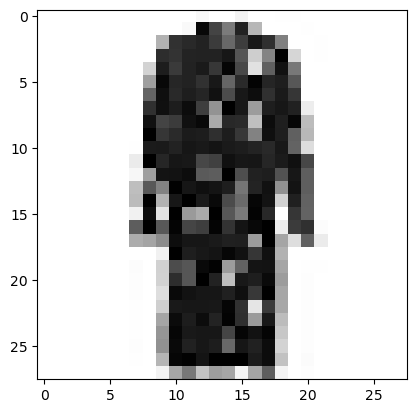

In [11]:
i = 34554
plt.imshow(tds[i]['image'].view(28, 28)), get_label(tds[i]['label'])

In [12]:
def collate_dict(ds):
    ig = itemgetter(*ds.features)
    def _f(batch): return ig(default_collate(batch))
    return _f

In [13]:
dl = DataLoader(tds, batch_size=64, collate_fn=collate_dict(tds))

In [14]:
next(iter(dl))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5,
         3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0,
         5, 5]))

<br><br>**Plotting images**

In [15]:
img = tds[0]['image']

<Axes: title={'center': 'boot'}>

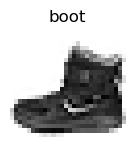

In [18]:
show_image(img, shape=[28, 28], title='boot')

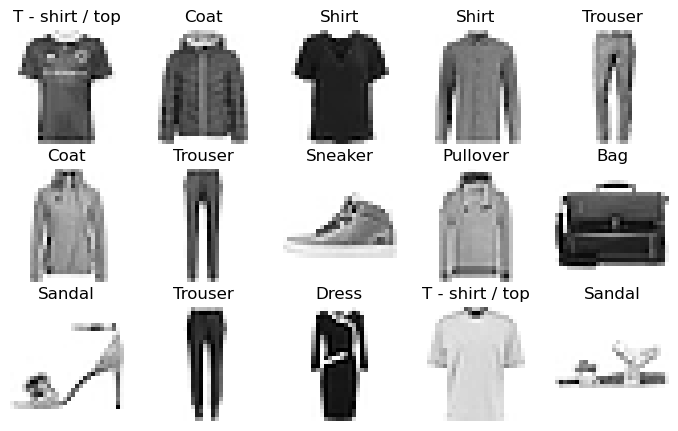

In [25]:
images = tds[-15:]
titles = [get_label(l) for l in images['label']]
show_images(images['image'], titles=titles, shape=[28, 28], nrows=3, ncols=5, imsize=(1.7, 1.7))